# <center> Построение адаптивных моделей в statsmodels </center>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

В библиотеке **statsmodels** реализованы модели прогнозирования, в т. ч. модель Хольта-Уинтерса. Все рассмотренные ранее модели, в основе которых лежит метод экспоненциального сглаживания, реализованы в модуле `statsmodels.tsa.holtwinters`.

## 1. Простое экспоненциальное сглаживание

Функция `SimpleExpSmoothing` предназначена для построения простого экспоненциального сглаживания. Построим модель экспоненциального сглаживания для прогнозирования объемов пассажирских авиаперевозок в Австралии.

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [6]:
ausair = pd.read_csv('data/ausair.csv', index_col='Year', parse_dates=True)
ausair = ausair['Passengers'][20:]
ausair.index = pd.DatetimeIndex(ausair.index, freq='YS')

В качестве аргумента фукнции `SimpleExpSmoothing` выступает исходный временной ряд. Для опредения оптимального параметра сглаживания $\alpha$ воспользуемся методом `fit()` модели.

In [9]:
ses = SimpleExpSmoothing(ausair).fit()

Помимо параметра сглаживания $\alpha$ функция `SimpleExpSmoothing` определяет начальное значение уровня $l_0$, которое также влияет на результат прогнозирования. Значения $\alpha$ и $l_0$ можно задать вручную:

In [11]:
y0 = ausair.values[0]
ses_lvl = SimpleExpSmoothing(ausair).fit(smoothing_level=0.8, initial_level=y0, optimized=False)

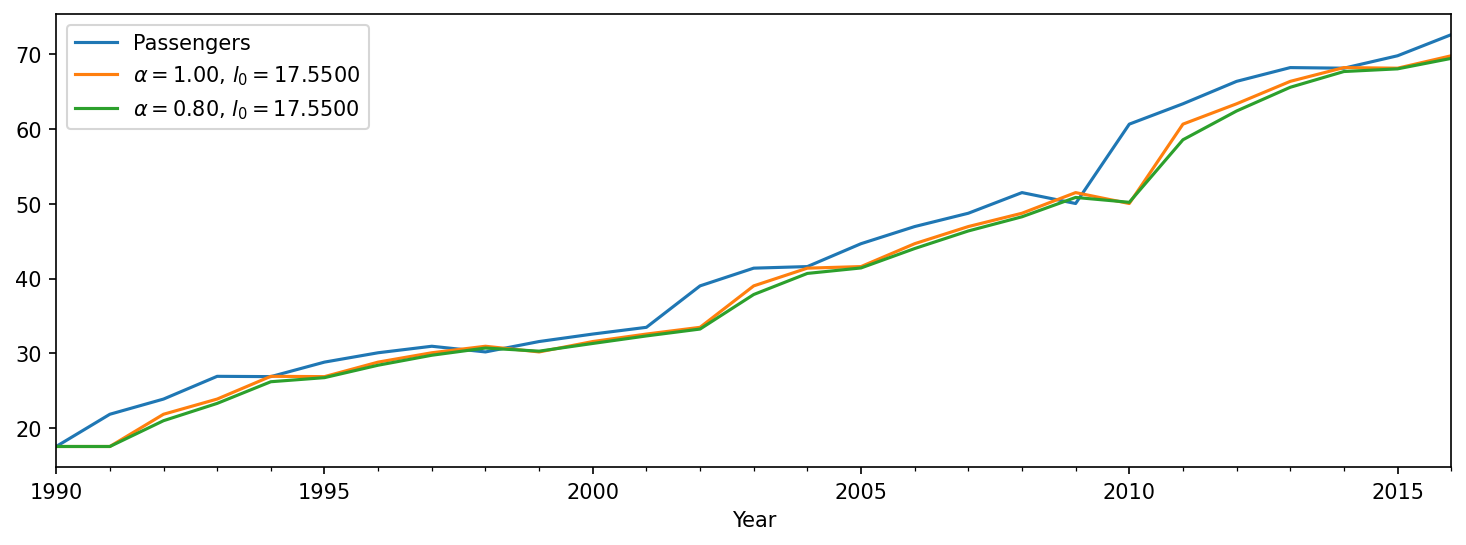

In [12]:
plt.figure(figsize=(12, 4), dpi=150)
ausair.plot(legend=True)
ses.fittedvalues.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl.fittedvalues.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                            r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

Для построения прогноза воспользуемся методом `.forecast()`, указав горизонт прогнозирования.

In [13]:
ses_forecast = ses.forecast(10)
ses_lvl_forecast = ses_lvl.forecast(10)

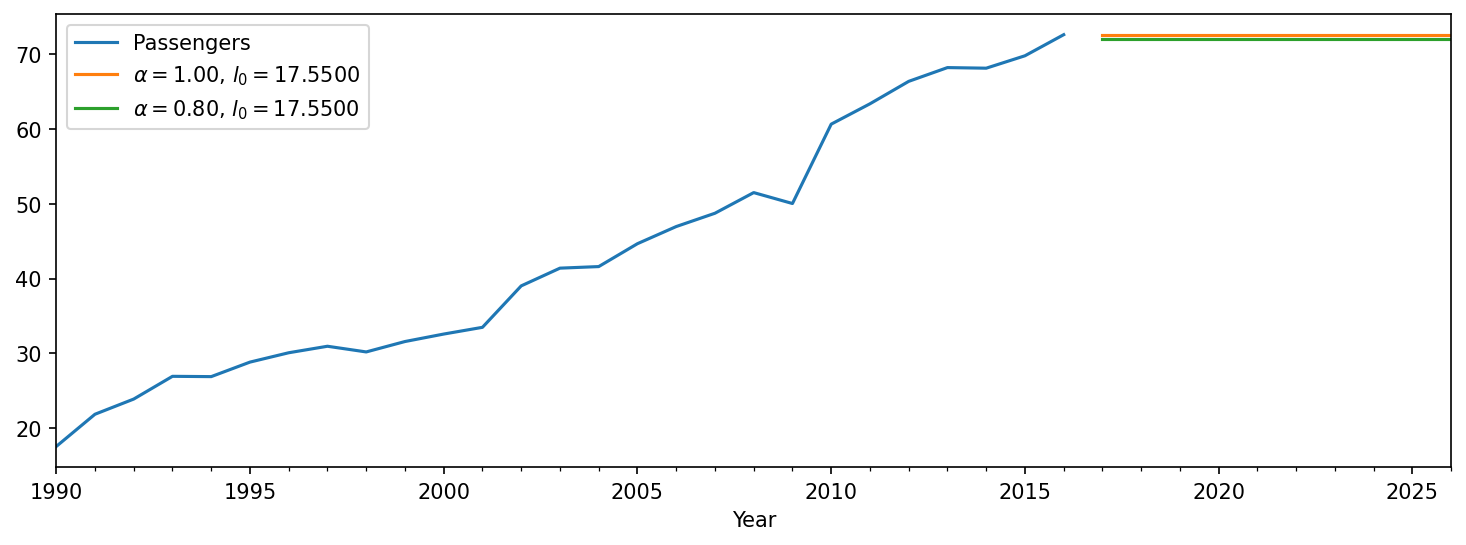

In [14]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
ses_forecast.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                    r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl_forecast.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

**Важно!** Если не задан период наблюдений, то statsmodels может построить прогноз с неожиданного индекса. Чтобы явно передать, для каких дат необходимо построить прогноз, можно воспользоваться методом `.predict(start, end)`.

In [15]:
start = ausair.index[-1] + pd.DateOffset(years=1)
end = start + pd.DateOffset(years=9)
start, end

(Timestamp('2017-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'))

In [16]:
ses.predict(start=start, end=end)

2017-01-01    72.6
2018-01-01    72.6
2019-01-01    72.6
2020-01-01    72.6
2021-01-01    72.6
2022-01-01    72.6
2023-01-01    72.6
2024-01-01    72.6
2025-01-01    72.6
2026-01-01    72.6
Freq: AS-JAN, dtype: float64

## 2. Метод Хольта

Для рядов с трендом можно воспользоваться функцией `Holt`.

In [17]:
from statsmodels.tsa.holtwinters import Holt

In [19]:
holt = Holt(ausair).fit()

b0 = ausair.values[1] - ausair.values[0]
holt_initial = Holt(ausair).fit(smoothing_level=0.59, smoothing_trend=0.43,
                                initial_level=y0, initial_trend=b0, 
                                optimized=False)

In [20]:
alpha = holt_initial.model.params['smoothing_level']
beta = holt_initial.model.params['smoothing_trend']
l0 = holt_initial.model.params['initial_level']
b0 = holt_initial.model.params['initial_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.59, beta = 0.43
l0  = 17.55, b0 = 4.31


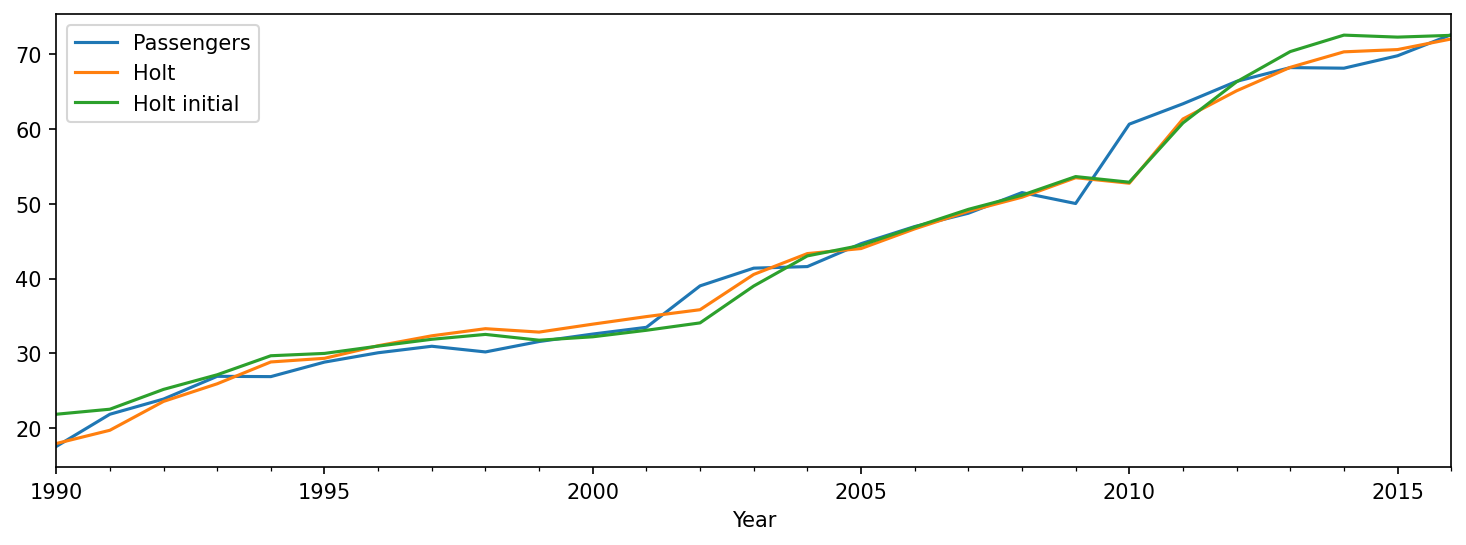

In [21]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt.fittedvalues.rename('Holt').plot(legend=True)
holt_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

In [ ]:
#version 0.12.2
#pip install -U statsmodels

In [22]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [24]:
holt_damped = Holt(ausair, damped_trend=True).fit()

b0 = ausair.values[1] - ausair.values[0]
holt_damped_initial = Holt(ausair, damped_trend=True).fit(smoothing_level=0.39, 
                                                          smoothing_trend=0.10,
                                                          damping_trend=0.9,
                                                          initial_level=y0, initial_trend=b0, 
                                                          optimized=False)

In [25]:
alpha = holt_damped.model.params['smoothing_level']
beta = holt_damped.model.params['smoothing_trend']
l0 = holt_damped.model.params['initial_level']
b0 = holt_damped.model.params['initial_trend']
phi = holt_damped.model.params['damping_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta), 'phi = {:.2f}'.format(phi))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.84, beta = 0.00 phi = 0.99
l0  = 15.65, b0 = 2.24


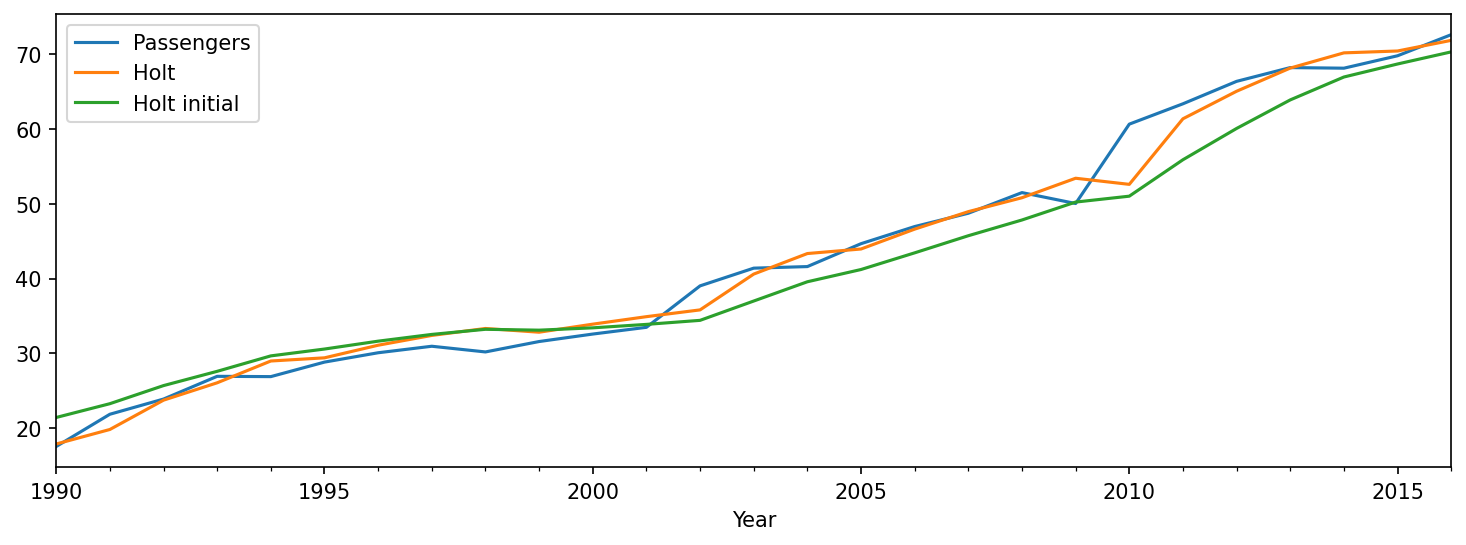

In [26]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt_damped.fittedvalues.rename('Holt').plot(legend=True)
holt_damped_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

## 3. Метод Хольта-Уинтерса

Модель Хольта-Уинтерса для рядов с сезонностью реализована в `ExponentialSmoothing`.

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

<a href='https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>Документация</a>

<div class="alert alert-info">

<h3> Задание</h3>
<p></p>
<ul>1. Постройте модель Хольта-Уинтерса для ряда <b>passengers.csv</b>.</ul>
<ul>2. Оцените качество аппроксимации с помощью среднеквадратичной ошибки.</ul>
<ul>3. Постройте прогноз на 1 год вперед и отобразите его на графике.</ul>
<p></p>
  
</div>

In [55]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
passengers

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


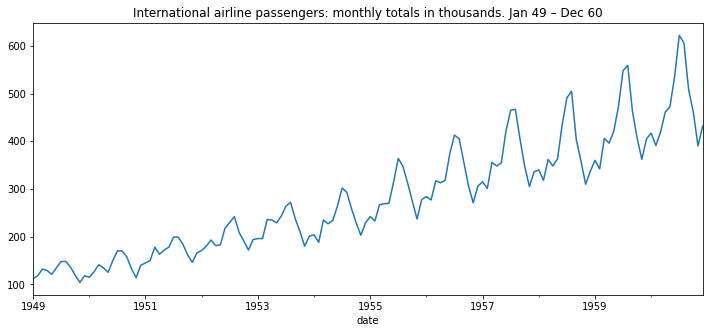

In [56]:
passengers['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.show()

In [57]:
passengers = passengers['num_passengers']
passengers.index = pd.DatetimeIndex(passengers.index, freq = 'MS')
passengers

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: num_passengers, Length: 144, dtype: int64

In [64]:
ses = ExponentialSmoothing(passengers, trend = 'add', seasonal = 'mul', seasonal_periods = 12, freq = 'MS').fit()

In [65]:
print(f'Standard deviation\nInitial: {passengers.values.std()}', f'\nFitted: {ses.fittedvalues.values.std()}')

Standard deviation
Initial: 119.54904153277147 
Fitted: 117.33759524996152


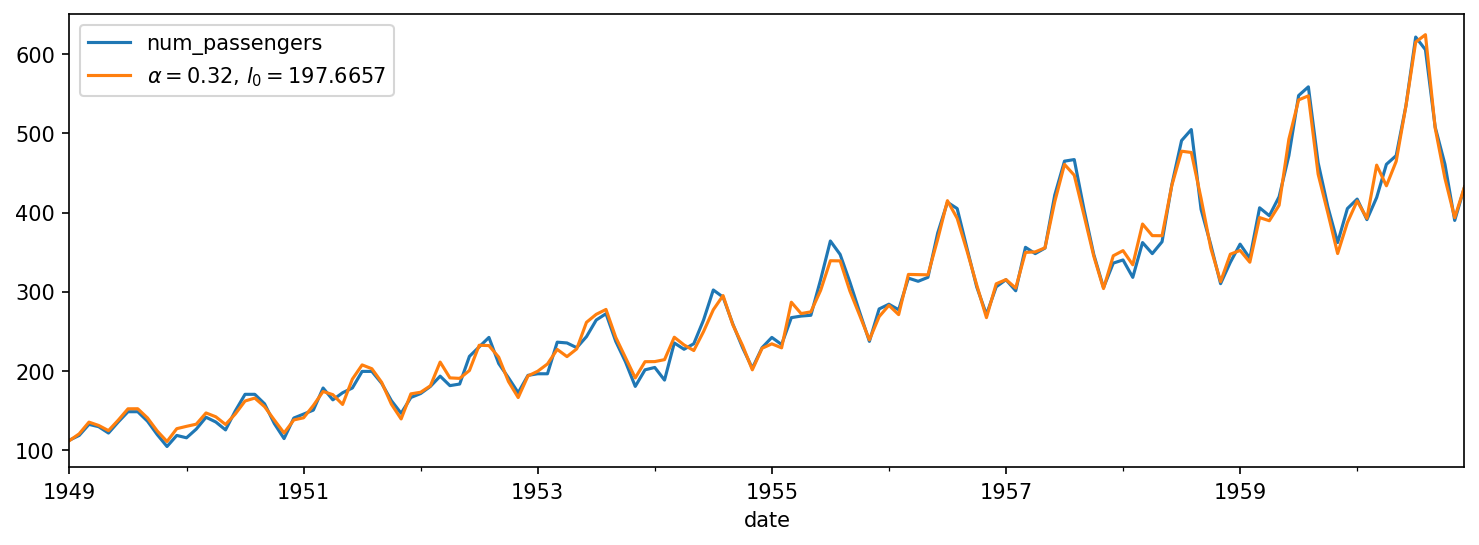

In [68]:
plt.figure(figsize=(12,4), dpi=150)
passengers.plot(legend=True)
ses.fittedvalues.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
plt.show()

In [69]:
ses_prognosis = ses.forecast(12)

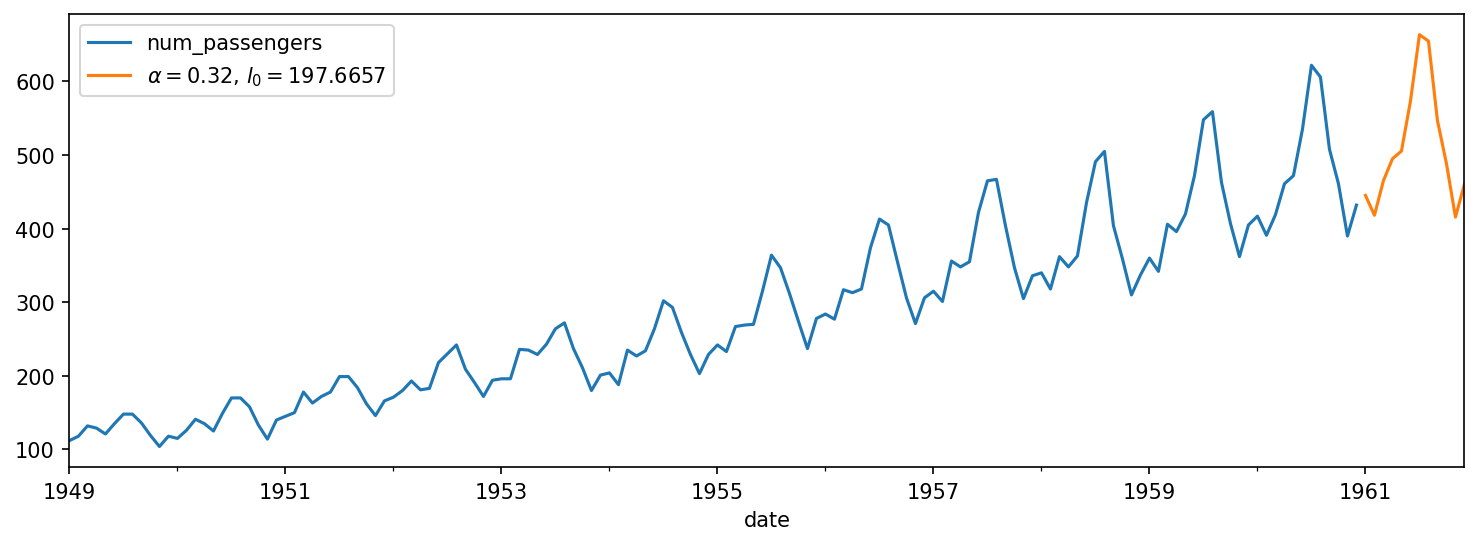

In [70]:
plt.figure(figsize=(12,4), dpi=150)
passengers.plot(legend=True)
ses_prognosis.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                     r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
plt.show()

<div class="alert alert-warning">

<h3> Домашнее задание</h3>    
    
<p></p> 
Выполнять в отдельном файле!
    
<ul>1. Для <b>своего</b> ряда (см. папку Данные на de.unecon) определите наилучшую адаптивную модель прогнозирования. Для этого загрузите данные и отобразите их на графике. Есть ли в ряде тренд, сезонность?</ul>
    
<ul>2. С помощью библиотеки statsmodels обучите выбранную модель и постройте прогноз. Отобразите результат на графике.</ul>
    
<ul>3. Вычислите среднеквадратичную ошибку для оценки качества аппроксимации.</ul>
<p></p>
  
</div>